### Training an LLM

1. Iterate over training epochs (one epoch is a complete pass over a training set).
2. Iterate over batches in each training epoch (# of batches = training set size / size of each batch).
3. Reset loss gradients from previous batch iteration.
4. Calculate loss on current batch.
5. Backward pass to calculate loss gradients. 
6. Update model weights using loss gradients. 
7. Print training and validation set losses.
8. Generate sample text for visual inspection.

In [1]:
import torch
from Chapter04 import GPTModel, create_dataloader_v1, generate_text_simple
from Chapter05 import calc_loss_batch, calc_loss_loader, text_to_token_ids, token_ids_to_text, tokeniser

GPT_CONFIG_124M = {
    "vocab_size": 50_257,
    "context_length": 256, # shortened from 1,024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [2]:
# Read in short story again
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [3]:
# Split dataset into train/validation sets
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
test_data = text_data[split_idx:]

In [4]:
# Create respective data loaders
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

test_loader = create_dataloader_v1(
    test_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [5]:
# Step 7
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout is disabled for stable, reproducible results
    with torch.no_grad(): # disables gradient tracking
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [6]:
# Step 8
def generate_and_print_sample(model, tokeniser, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokeniser).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, 
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokeniser)
    print(decoded_text.replace("\n", " "))
    model.train()

In [7]:
def train_model_simple(model, train_loader, val_loader,
                       optimiser, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokeniser):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs): # step 1
        model.train()
        for input_batch, target_batch in train_loader: # step 2
            optimiser.zero_grad() # step 3
            loss = calc_loss_batch( # step 4
                input_batch, target_batch, model, device
            )
            loss.backward() # step 5
            optimiser.step() # step 6
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: # step 7
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample( # step 8
            model, tokeniser, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimiser = torch.optim.AdamW(
    model.parameters(), # return all trainable weight parameters of the model
    lr=0.0004,
    weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimiser, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokeniser=tokeniser
)

Epoch 1 (Step 000000): Train loss 9.840, Val loss 10.090
Epoch 1 (Step 000005): Train loss 8.254, Val loss 8.252
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000010): Train loss 6.723, Val loss 7.038
Epoch 2 (Step 000015): Train loss 6.107, Val loss 6.575
Every effort moves you, the, the, the, the, the, the, the.                                   
Epoch 3 (Step 000020): Train loss 5.534, Val loss 6.434
Epoch 3 (Step 000025): Train loss 5.581, Val loss 6.437
Every effort moves you, and and, and a a . . . a a a of the and a, and a, and, and, and, and, and, and the of the of the of the of the of the and a, and, and,
Epoch 4 (Step 000030): Train loss 5.100, Val loss 6.477
Epoch 4 (Step 000035): Train loss 4.914, Val loss 6.452
Every effort moves you in the picture. Gisburn's't to me to a me. Gisburn was no's--I"I had been to me to me to me his pictures he had been his painting his a _ a to me to me to me
Epoch 5 (Step 000040): Train loss 4.696, 

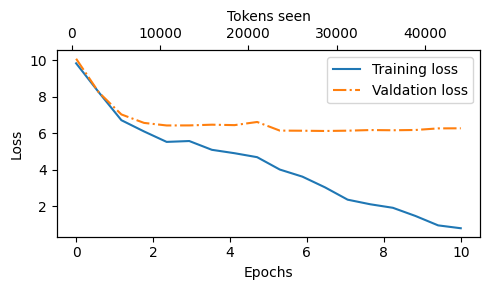

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Valdation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)